In [1]:
! python -m pip install tf-models-official 
! python -m pip install tensorflow 
! python -m pip install tensorflow-text 
! python -m pip install spacy
! python -m spacy download en_core_web_sm
! python -m spacy validate 

     |████████████████████████████████| 1.8 MB 13.3 MB/s 
     |████████████████████████████████| 1.1 MB 36.7 MB/s 
     |████████████████████████████████| 4.9 MB 11.8 MB/s 
     |████████████████████████████████| 90 kB 9.4 MB/s 
     |████████████████████████████████| 596 kB 45.6 MB/s 
     |████████████████████████████████| 1.2 MB 41.3 MB/s 
     |████████████████████████████████| 99 kB 9.2 MB/s 
     |████████████████████████████████| 47.6 MB 101 kB/s 
     |████████████████████████████████| 213 kB 43.7 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 352 kB 34.0 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22258 sha256=67b616752c11468c376c8450c49345a17fa40415ff41ea0fd4a100c8672fa8dd
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=e588cf97d9a36610

In [2]:
import numpy as np 
import pandas as pd 
import os
import time
from tqdm import tqdm

In [3]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import re
import string
from bs4 import BeautifulSoup as bs
# Model Training
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras import layers, Model
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.losses import BinaryCrossentropy
import official.nlp.optimization
from official.nlp.optimization import create_optimizer # AdamW optimizer
from sklearn.metrics import roc_curve, confusion_matrix, f1_score
# Visualization
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib import rcParams
# Version
from platform import python_version


In [4]:
RANDOM_SEED = 77
nlp = spacy.load('en_core_web_sm') 
pd.set_option('display.max_colwidth', None) # Expand DataFrame column width
rcParams['figure.figsize'] = (10, 6) # Custom plot dimensions
sns.set_theme(palette='muted', style='whitegrid') # Seaborn plot theme

In [5]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    in_colab = True
except:
    in_colab = False

Mounted at /content/drive


In [6]:
if in_colab:
    # input_path = '/content/drive/MyDrive/NLP Project/codes/input'
    input_path = '/content/drive/MyDrive/ColabNotebooks/disaster_tweets/input'
    current_path = '/content/drive/MyDrive/ColabNotebooks/disaster_tweets'
    path = input_path + '/train.csv'
    path_test = input_path + '/test.csv'
else:
    path = '../CS6120Project/input/train.csv'
    path_test = '../CS6120Project/input/test.csv'

In [7]:
df = pd.read_csv(path)
print(df.shape)
df.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [8]:
df_test = pd.read_csv(path_test)
print(df_test.shape)
df_test.head()

(3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Data Analysis

In [9]:
duplicates = df[df.duplicated(['text', 'target'], keep=False)]
print(f'Train Duplicate Entries (text, target): {len(duplicates)}')
duplicates.head()

Train Duplicate Entries (text, target): 157


,id,keyword,location,text,target
40,59,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw,0
48,68,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw,0
106,156,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vAM5POdGyw | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/zEVakJaPcz,0
115,165,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vAM5POdGyw | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/zEVakJaPcz,0
118,171,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/THyzOMVWU0 | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/83jOO0xk29,0


In [10]:
df.drop_duplicates(['text', 'target'], inplace=True, ignore_index=True)
print(df.shape, df_test.shape)

(7521, 5) (3263, 4)


In [11]:
new_duplicates = df[df.duplicated(['keyword', 'text'], keep=False)]
new_duplicates[['text', 'target']].sort_values(by='text')
print(f'Train Duplicate Entries (keyword, text): {len(new_duplicates)}')
df.drop(list(new_duplicates.index), inplace=True)

Train Duplicate Entries (keyword, text): 30


In [12]:
df = df.reset_index(drop=True)
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
...,...,...,...,...,...
7486,10863,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: UPDATE: FIRE crews have evacuated up to 30 passengers who were tr... http://t.co/EYSVvzA7Qm,1
7487,10864,NaN,NaN,on the flip side I'm at Walmart and there is a bomb and everyone had to evacuate so stay tuned if I blow up or not,1
7488,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site mosque - Reuters via World - Google News - Wall ... http://t.co/nF4IculOje,1
7489,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1


In [13]:
df['target'].value_counts() / len(df)

0    0.574022
1    0.425978
Name: target, dtype: float64

# Preprocessing Text and EDA

In [14]:
text = df['text']
target = df['target']
test_text = df_test['text']

# Print random samples from the training text 
for i in np.random.randint(500, size=5):
    print(f'Tweet #{i}: ', text[i], '=> Target: ', target[i])

Tweet #493:  im feeling attacked http://t.co/91jvYCxXVi => Target:  0
Tweet #341:  Well done Celtic Fingers crossed for Aberdeen tomorrow night! 
Armageddon eh.... ?? => Target:  0
Tweet #245:  :StarMade: :Stardate 3: :Planetary Annihilation:: http://t.co/I2hHvIUmTm via @YouTube => Target:  1
Tweet #183:  Pakistan air ambulance helicopter crash kills nine http://t.co/8E7rY8eBMf => Target:  1
Tweet #110:  So i guess no one actually wants any free Aftershock TC..... => Target:  0


In [15]:
lookup_dict = {
  'abt' : 'about',
  'afaik' : 'as far as i know',
  'bc' : 'because',
  'bfn' : 'bye for now',
  'bgd' : 'background',
  'bh' : 'blockhead',
  'br' : 'best regards',
  'btw' : 'by the way',
  'cc': 'carbon copy',
  'chk' : 'check',
  'dam' : 'do not annoy me',
  'dd' : 'dear daughter',
  'df': 'dear fiance',
  'ds' : 'dear son',
  'dyk' : 'did you know',
  'em': 'email',
  'ema' : 'email address',
  'ftf' : 'face to face',
  'fb' : 'facebook',
  'ff' : 'follow friday', 
  'fotd' : 'find of the day',
  'ftw': 'for the win',
  'fwiw' : 'for what it is worth',
  'gts' : 'guess the song',
  'hagn' : 'have a good night',
  'hand' : 'have a nice day',
  'hotd' : 'headline of the day',
  'ht' : 'heard through',
  'hth' : 'hope that helps',
  'ic' : 'i see',
  'icymi' : 'in case you missed it',
  'idk' : 'i do not know',
  'ig': 'instagram',
  'iirc' : 'if i remember correctly',
  'imho' : 'in my humble opinion',
  'imo' : 'in my opinion',
  'irl' : 'in real life',
  'iwsn' : 'i want sex now',
  'jk' : 'just kidding',
  'jsyk' : 'just so you know',
  'jv' : 'joint venture',
  'kk' : 'cool cool',
  'kyso' : 'knock your socks off',
  'lmao' : 'laugh my ass off',
  'lmk' : 'let me know', 
  'lo' : 'little one',
  'lol' : 'laugh out loud',
  'mm' : 'music monday',
  'mirl' : 'meet in real life',
  'mrjn' : 'marijuana',
  'nbd' : 'no big deal',
  'nct' : 'nobody cares though',
  'njoy' : 'enjoy',
  'nsfw' : 'not safe for work',
  'nts' : 'note to self',
  'oh' : 'overheard',
  'omg': 'oh my god',
  'oomf' : 'one of my friends',
  'orly' : 'oh really',
  'plmk' : 'please let me know',
  'pnp' : 'party and play', 
  'qotd' : 'quote of the day',
  're' : 'in reply to in regards to',
  'rtq' : 'read the question',
  'rt' : 'retweet',
  'sfw' : 'safe for work',
  'smdh' : 'shaking my damn head', 
  'smh' : 'shaking my head',
  'so' : 'significant other',
  'srs' : 'serious',
  'tftf' : 'thanks for the follow',
  'tftt' : 'thanks for this tweet',
  'tj' : 'tweetjack',
  'tl' : 'timeline',
  'tldr' : 'too long did not read',
  'tmb' : 'tweet me back',
  'tt' : 'trending topic',
  'ty' : 'thank you',
  'tyia' : 'thank you in advance',
  'tyt' : 'take your time',
  'tyvw' : 'thank you very much',
  'w': 'with', 
  'wtv' : 'whatever',
  'ygtr' : 'you got that right',
  'ykwim' : 'you know what i mean',
  'ykyat' : 'you know you are addicted to',
  'ymmv' : 'your mileage may vary',
  'yolo' : 'you only live once',
  'yoyo' : 'you are on your own',
  'yt': 'youtube',
  'yw' : 'you are welcome',
  'zomg' : 'oh my god to the maximum'
}

In [16]:
def lemmatize_text(text, nlp=nlp):
    doc = nlp(text)    
    lemma_sent = [i.lemma_ for i in doc if not i.is_stop]    
    
    return ' '.join(lemma_sent)  

def abbrev_conversion(text):
    words = text.split() 
    abbrevs_removed = [] 
    
    for i in words:
        if i in lookup_dict:
            i = lookup_dict[i]
        abbrevs_removed.append(i)
            
    return ' '.join(abbrevs_removed)

def standardize_text(text_data):    
    entity_pattern = re.compile(r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)') 
    url_pattern = re.compile(r'(?:\@|http?\://|https?\://|www)\S+')
    retweet_pattern = re.compile(r'^(RT|RT:)\s+')
    digit_pattern = re.compile(r'[\d]+')
    # From https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    
    # Remove urls
    url_strip = text_data.apply(lambda x: re.sub(url_pattern, '', x) if pd.isna(x) != True else x)
    # Parse the HTML
    html_parse = url_strip.apply(lambda x: bs(x, 'html.parser').get_text() if pd.isna(x) != True else x)
    # Remove rewteets
    retweet_strip = html_parse.apply(lambda x: re.sub(retweet_pattern, '', x) if pd.isna(x) != True else x)
    # Remove emojis
    emoji_strip = retweet_strip.apply(lambda x: re.sub(emoji_pattern, '', x) if pd.isna(x) != True else x)
    # Remove entities
    entity_strip = emoji_strip.apply(lambda x: re.sub(entity_pattern, '', x) if pd.isna(x) != True else x)
    # Lowercase the strings
    lowercase = entity_strip.apply(lambda x: str.lower(x) if pd.isna(x) != True else x)               
    # Remove punctuation
    punct_strip = lowercase.apply(lambda x: re.sub(f'[{re.escape(string.punctuation)}]', '', x) if pd.isna(x) != True else x) 
    # Convert abbreviations to words
    abbrev_converted = punct_strip.apply(lambda x: abbrev_conversion(x) if pd.isna(x) != True else x)
    # Remove digits
    digit_strip = abbrev_converted.apply(lambda x: re.sub(digit_pattern, '', x) if pd.isna(x) != True else x)    
    # Lemmatize text and filter stopwords
    lemma_and_stop = digit_strip.apply(lambda x: lemmatize_text(x) if pd.isna(x) != True else x)
    
    return lemma_and_stop

In [17]:
clean_text = np.asarray(standardize_text(text))
test_clean_text = np.asarray(standardize_text(test_text))

# Print random samples from the cleaned training text
for i in np.random.randint(500, size=5):
    print(f'Tweet #{i}: ', clean_text[i], '=> Target: ', target[i])

Tweet #368:  beyonce pick fan army beyhive => Target:  0
Tweet #169:  air ambulance scene crash car lorry emsne => Target:  1
Tweet #167:  early wake sister beg come ride wher ambulance hospital rodkiai => Target:  1
Tweet #68:  accident center lane block santaclara nb great america pkwy bayarea traffic => Target:  1
Tweet #471:  fact atomic bomb call little boy fat man say lot mentality go attack => Target:  1


# Data Preparation for Training

In [18]:
df['clean_text'] = pd.DataFrame(clean_text)
df_test['clean_text'] = pd.DataFrame(test_clean_text)

In [19]:
df['tweet_len'] = df['clean_text'].apply(lambda x: len(x))

In [20]:
# Load the sentence encoder
sentence_enc = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')

In [21]:
def extract_keywords(text, nlp=nlp):
    potential_keywords = []
    TOP_KEYWORD = -1
    # Create a list for keyword parts of speech
    pos_tag = ['ADJ', 'NOUN', 'PROPN']
    doc = nlp(text)
    
    for i in doc:
        if i.pos_ in pos_tag:
            potential_keywords.append(i.text)

    document_embed = sentence_enc([text])
    potential_embed = sentence_enc(potential_keywords)    
    
    vector_distances = cosine_similarity(document_embed, potential_embed)
    keyword = [potential_keywords[i] for i in vector_distances.argsort()[0][TOP_KEYWORD:]]

    return keyword

def keyword_filler(keyword, text):
    if pd.isnull(keyword):
        try:
            keyword = extract_keywords(text)[0]
        except:
            keyword = '' 
        
    return keyword

In [22]:
df['keyword_fill'] = pd.DataFrame(list(map(keyword_filler, df['keyword'], df['clean_text']))).astype(str)
df_test['keyword_fill'] = pd.DataFrame(list(map(keyword_filler, df_test['keyword'], df_test['clean_text']))).astype(str)

print('Null Training Keywords => ', df['keyword_fill'].isnull().any())
print('Null Test Keywords => ', df_test['keyword_fill'].isnull().any())

Null Training Keywords =>  False
Null Test Keywords =>  False


In [23]:
df['keyword_fill'] = pd.DataFrame(standardize_text(df['keyword_fill']))
df_test['keyword_fill'] = pd.DataFrame(standardize_text(df_test['keyword_fill']))

In [24]:
df.head()

,id,keyword,location,text,target,clean_text,tweet_len,keyword_fill
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,deed reason earthquake allah forgive,36,earthquake
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,37,forest
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,resident ask shelter place notify officer evacuation shelter place order expect,79,shelter
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,people receive wildfire evacuation order california,53,wildfire
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,get send photo ruby alaska smoke wildfire pour school,53,wildfire


In [25]:
df_test.head()

,id,keyword,location,text,clean_text,keyword_fill
0,0,NaN,NaN,Just happened a terrible car crash,happen terrible car crash,crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone.",hear earthquake different city stay safe,earthquake
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",forest fire spot pond geese flee street save,geese
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse light spokane wildfire,wildfire
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan,taiwan


In [26]:
train_features = df[['clean_text','keyword_fill']]
test_features = df_test[['clean_text', 'keyword_fill']]

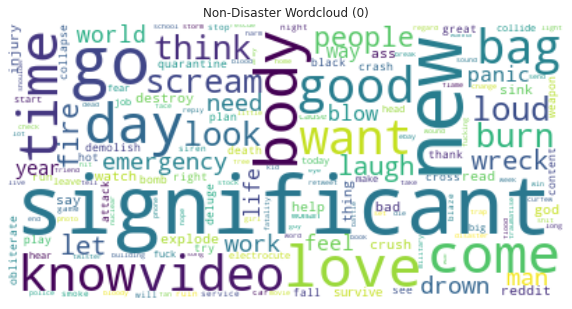

In [40]:
word_cloud_0 = WordCloud(collocations=False, background_color='white').generate(' '.join(df['clean_text'][df['target']==0]))
plt.imshow(word_cloud_0, interpolation='bilinear')
plt.title('Non-Disaster Wordcloud (0)')
plt.axis('off')
plt.show()

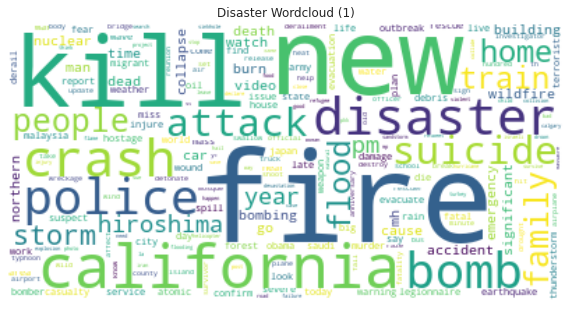

In [41]:
word_cloud_1 = WordCloud(collocations=False, background_color='white').generate(' '.join(df['clean_text'][df['target']==1]))
plt.imshow(word_cloud_1, interpolation='bilinear')
plt.title('Disaster Wordcloud (1)')
plt.axis('off')
plt.show()

In [27]:
train_features[:5]

,clean_text,keyword_fill
0,deed reason earthquake allah forgive,earthquake
1,forest fire near la ronge sask canada,forest
2,resident ask shelter place notify officer evacuation shelter place order expect,shelter
3,people receive wildfire evacuation order california,wildfire
4,get send photo ruby alaska smoke wildfire pour school,wildfire


In [28]:
test_features[:5]

,clean_text,keyword_fill
0,happen terrible car crash,crash
1,hear earthquake different city stay safe,earthquake
2,forest fire spot pond geese flee street save,geese
3,apocalypse light spokane wildfire,wildfire
4,typhoon soudelor kill china taiwan,taiwan


In [29]:
print(train_features.shape)
print(test_features.shape)

(7491, 2)
(3263, 2)


In [30]:
train_x, val_x, train_y, val_y = train_test_split(
    train_features,
    target,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)

(5992, 2)
(5992,)
(1499, 2)
(1499,)


In [31]:
# Create TensorFlow Datasets 
train_ds = tf.data.Dataset.from_tensor_slices((dict(train_x), train_y))
val_ds = tf.data.Dataset.from_tensor_slices((dict(val_x), val_y))
test_ds = tf.data.Dataset.from_tensor_slices(dict(test_features))


In [32]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

BUFFER_SIZE = 1000
BATCH_SIZE = 32

def configure_dataset(dataset, shuffle=False, test=False):
    # Configure the tf dataset for cache, shuffle, batch, and prefetch
    if shuffle:
        dataset = dataset.cache()\
                        .shuffle(BUFFER_SIZE, seed=RANDOM_SEED, reshuffle_each_iteration=True)\
                        .batch(BATCH_SIZE, drop_remainder=True).prefetch(AUTOTUNE)
    elif test:
        dataset = dataset.cache()\
                        .batch(BATCH_SIZE, drop_remainder=False).prefetch(AUTOTUNE)
    else:
        dataset = dataset.cache()\
                        .batch(BATCH_SIZE, drop_remainder=True).prefetch(AUTOTUNE)
    return dataset

In [33]:
# Configure the datasets
train_ds = configure_dataset(train_ds, shuffle=True)
val_ds = configure_dataset(val_ds)
test_ds = configure_dataset(test_ds, test=True)

In [34]:
# Print the dataset specifications
print(train_ds.element_spec)
print(val_ds.element_spec)
print(test_ds.element_spec)

({'clean_text': TensorSpec(shape=(32,), dtype=tf.string, name=None), 'keyword_fill': TensorSpec(shape=(32,), dtype=tf.string, name=None)}, TensorSpec(shape=(32,), dtype=tf.int64, name=None))
({'clean_text': TensorSpec(shape=(32,), dtype=tf.string, name=None), 'keyword_fill': TensorSpec(shape=(32,), dtype=tf.string, name=None)}, TensorSpec(shape=(32,), dtype=tf.int64, name=None))
{'clean_text': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'keyword_fill': TensorSpec(shape=(None,), dtype=tf.string, name=None)}


# Building the Classifier Model

In [35]:
result = dict()

In [36]:
# BERT encoder w/ preprocessor
bert_preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', name='BERT_preprocesser')
# loading pre-trained BERT model with 12 hidden layers, 768 hidden unit size, and 12 attention heads
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4', trainable=True, name='BERT_encoder')
# Keyword embedding layer
nnlm_embed = hub.KerasLayer('https://tfhub.dev/google/nnlm-en-dim50/2', name='embedding_layer')

In [37]:
def build_model(preprocessor, encoder, name):
    
    # Construct text layers
    text_input = layers.Input(shape=(), dtype=tf.string, name='clean_text') # Name matches df heading
    encoder_inputs = preprocessor(text_input)
    encoder_outputs = encoder(encoder_inputs)
    # pooled_output returns [batch_size, hidden_layers]
    pooled_output = encoder_outputs["pooled_output"]          
    bert_dropout = layers.Dropout(0.1, name='BERT_dropout')(pooled_output)   
    
    # Construct keyword layers
    key_input = layers.Input(shape=(), dtype=tf.string, name='keyword_fill') # Name matches df heading
    key_embed = nnlm_embed(key_input)
    key_flat = layers.Flatten()(key_embed)
    key_dense = layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(1e-4))(key_flat)
    key_dropout = layers.Dropout(0.5, name='dense_dropout')(key_dense)
    
    # Merge the layers and classify 
    merge = layers.concatenate([bert_dropout, key_dropout])
    dense = layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(1e-4))(merge)
    dropout = layers.Dropout(0.5, name='merged_dropout')(dense)    
    clf = layers.Dense(1, activation='sigmoid', name='classifier')(dropout)

    return Model([text_input, key_input], clf, name=name)

In [ ]:
# tf.keras.utils.plot_model(bert_classifier, show_shapes=False, dpi=96)

### BERT training

In [ ]:
# construction of AdamW optimizer
EPOCHS = 3
LEARNING_RATE = 5e-5

STEPS_PER_EPOCH = int(train_ds.unbatch().cardinality().numpy() / BATCH_SIZE)
VAL_STEPS = int(val_ds.unbatch().cardinality().numpy() / BATCH_SIZE)
# Calculate the train and warmup steps for the optimizer
TRAIN_STEPS = STEPS_PER_EPOCH * EPOCHS
WARMUP_STEPS = int(TRAIN_STEPS * 0.1)

adamw_optimizer = create_optimizer(
    init_lr=LEARNING_RATE,
    num_train_steps=TRAIN_STEPS,
    num_warmup_steps=WARMUP_STEPS
)

model_name = 'BERT'
bert_preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', name='BERT_preprocesser')
# loading pre-trained BERT model with 12 hidden layers, 768 hidden unit size, and 12 attention heads
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4', trainable=True, name='BERT_encoder')
bert_classifier = build_model(bert_preprocessor, bert_encoder, model_name)
bert_classifier.compile(
    loss=BinaryCrossentropy(from_logits=True), 
    optimizer= adamw_optimizer,
    metrics=[BinaryAccuracy(name='accuracy')]
)

start_time = time.time()
history_bert = bert_classifier.fit(
    train_ds, 
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,    
    validation_data= val_ds,
    validation_steps=VAL_STEPS
)
end_time = time.time()

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


187/187 [==============================] - 365s 2s/step - loss: 0.5541 - accuracy: 0.7520 - val_loss: 0.4633 - val_accuracy: 0.8077
Epoch 2/3
187/187 [==============================] - 341s 2s/step - loss: 0.3857 - accuracy: 0.8595 - val_loss: 0.4918 - val_accuracy: 0.8118
Epoch 3/3
187/187 [==============================] - 340s 2s/step - loss: 0.2775 - accuracy: 0.9084 - val_loss: 0.5438 - val_accuracy: 0.8091


In [ ]:
result[model_name] = {'training_time': end_time-start_time}
result[model_name]['val_accuracy'] = max(history_bert.history['val_accuracy'])
val_target = np.asarray([i[1] for i in list(val_ds.unbatch().as_numpy_iterator())])
val_predict = bert_classifier.predict(val_ds)
val_predict = val_predict > 0.5
result[model_name]['F1_score'] = f1_score(val_target, val_predict)

### Electra Training

In [ ]:
EPOCHS = 3
LEARNING_RATE = 1e-5

STEPS_PER_EPOCH = int(train_ds.unbatch().cardinality().numpy() / BATCH_SIZE)
VAL_STEPS = int(val_ds.unbatch().cardinality().numpy() / BATCH_SIZE)
# Calculate the train and warmup steps for the optimizer
TRAIN_STEPS = STEPS_PER_EPOCH * EPOCHS
WARMUP_STEPS = int(TRAIN_STEPS * 0.1)

adamw_optimizer = create_optimizer(
    init_lr=LEARNING_RATE,
    num_train_steps=TRAIN_STEPS,
    num_warmup_steps=WARMUP_STEPS
)

electra_preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
electra_encoder = hub.KerasLayer("https://tfhub.dev/google/electra_small/2", trainable=True, name="Electra_encoder")
model_name = 'Electra-small'
electra_classifier = build_model(electra_preprocessor, electra_encoder, model_name)
electra_classifier.compile(
    loss=BinaryCrossentropy(from_logits=True), 
    optimizer= adamw_optimizer,
    metrics=[BinaryAccuracy(name='accuracy')]
)

start_time = time.time()
history_electra = electra_classifier.fit(
    train_ds, 
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,    
    validation_data= val_ds,
    validation_steps=VAL_STEPS
)
end_time = time.time()

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


187/187 [==============================] - 139s 630ms/step - loss: 0.7125 - accuracy: 0.6093 - val_loss: 0.5643 - val_accuracy: 0.7303
Epoch 2/3
187/187 [==============================] - 117s 625ms/step - loss: 0.5615 - accuracy: 0.7572 - val_loss: 0.5407 - val_accuracy: 0.7656
Epoch 3/3
187/187 [==============================] - 117s 625ms/step - loss: 0.5308 - accuracy: 0.7821 - val_loss: 0.5519 - val_accuracy: 0.7507


In [ ]:
result[model_name] = {'training_time': end_time-start_time}
result[model_name]['val_accuracy'] = max(history_electra.history['val_accuracy'])
val_target = np.asarray([i[1] for i in list(val_ds.unbatch().as_numpy_iterator())])
val_predict = electra_classifier.predict(val_ds)
val_predict = val_predict > 0.5
result[model_name]['F1_score'] = f1_score(val_target, val_predict)

### ALBERT training

In [38]:
EPOCHS = 3
LEARNING_RATE = 1e-5

STEPS_PER_EPOCH = int(train_ds.unbatch().cardinality().numpy() / BATCH_SIZE)
VAL_STEPS = int(val_ds.unbatch().cardinality().numpy() / BATCH_SIZE)
# Calculate the train and warmup steps for the optimizer
TRAIN_STEPS = STEPS_PER_EPOCH * EPOCHS
WARMUP_STEPS = int(TRAIN_STEPS * 0.1)

adamw_optimizer = create_optimizer(
    init_lr=LEARNING_RATE,
    num_train_steps=TRAIN_STEPS,
    num_warmup_steps=WARMUP_STEPS
)

albert_preprocessor = hub.KerasLayer("http://tfhub.dev/tensorflow/albert_en_preprocess/3")
albert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_base/3", trainable=True, name="albert_encoder")
model_name = 'Albert-base'
albert_classifier = build_model(albert_preprocessor, albert_encoder, model_name)
albert_classifier.compile(
    loss=BinaryCrossentropy(from_logits=True), 
    optimizer= adamw_optimizer,
    metrics=[BinaryAccuracy(name='accuracy')]
)

start_time = time.time()
history_albert = albert_classifier.fit(
    train_ds, 
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,    
    validation_data= val_ds,
    validation_steps=VAL_STEPS
)
end_time = time.time()

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


187/187 [==============================] - 391s 2s/step - loss: 0.7143 - accuracy: 0.6738 - val_loss: 0.5201 - val_accuracy: 0.7724
Epoch 2/3
187/187 [==============================] - 377s 2s/step - loss: 0.5207 - accuracy: 0.7782 - val_loss: 0.5086 - val_accuracy: 0.7935
Epoch 3/3
187/187 [==============================] - 377s 2s/step - loss: 0.4510 - accuracy: 0.8185 - val_loss: 0.5019 - val_accuracy: 0.7955


In [39]:
result[model_name] = {'training_time': end_time-start_time}
result[model_name]['val_accuracy'] = max(history_albert.history['val_accuracy'])
val_target = np.asarray([i[1] for i in list(val_ds.unbatch().as_numpy_iterator())])
val_predict = albert_classifier.predict(val_ds)
val_predict = val_predict > 0.5
result[model_name]['F1_score'] = f1_score(val_target, val_predict)

In [ ]:
result

{'Albert-base': {'F1_score': 0.7614125753660638,
  'training_time': 1156.5787959098816,
  'val_accuracy': 0.8118206262588501},
 'BERT': {'F1_score': 0.7683429513602638,
  'training_time': 1125.6142642498016,
  'val_accuracy': 0.8118206262588501},
 'Electra-small': {'F1_score': 0.7246811702925732,
  'training_time': 422.6679632663727,
  'val_accuracy': 0.765625}}

In [ ]:
df_result = pd.DataFrame(result)
df_result = pd.DataFrame.transpose(df_result)
df_result.to_csv(current_path + '/results.csv')

# History plot, ROC curve plot and Confusion matrix for BERT classifier

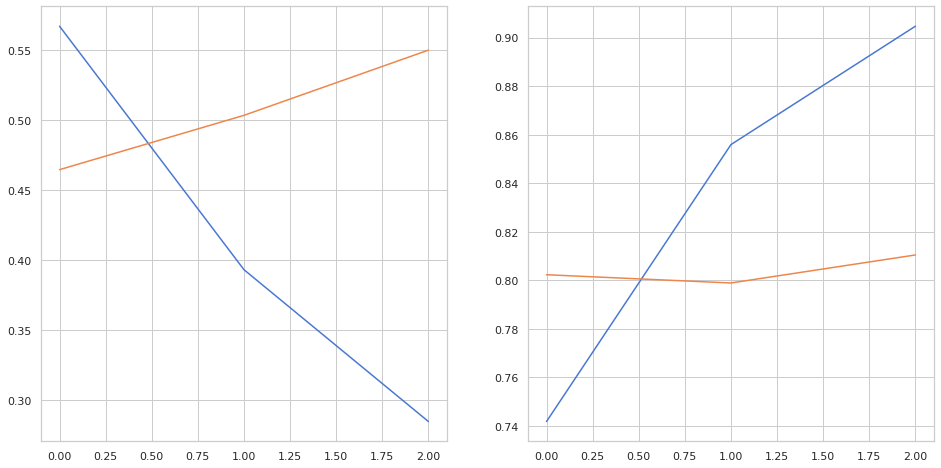

In [ ]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
plot_history(history_bert)

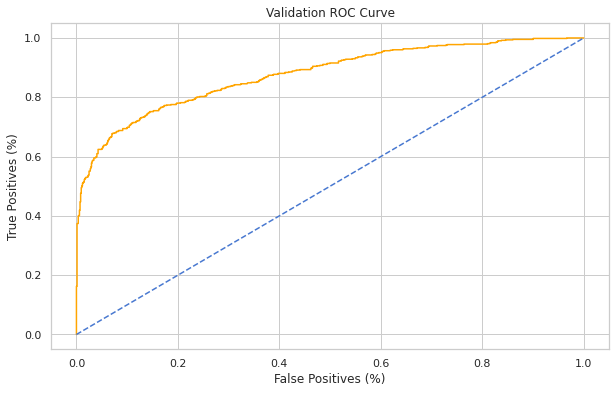

In [ ]:
val_target = np.asarray([i[1] for i in list(val_ds.unbatch().as_numpy_iterator())])
val_predict = bert_classifier.predict(val_ds)
fpr, tpr, _ = roc_curve(val_target, val_predict)
plt.plot(fpr, tpr, color='orange')
plt.plot([0,1], [0,1], linestyle='--')
plt.title('Validation ROC Curve')
plt.xlabel('False Positives (%)')
plt.ylabel('True Positives (%)')
plt.grid(True)    
plt.show()

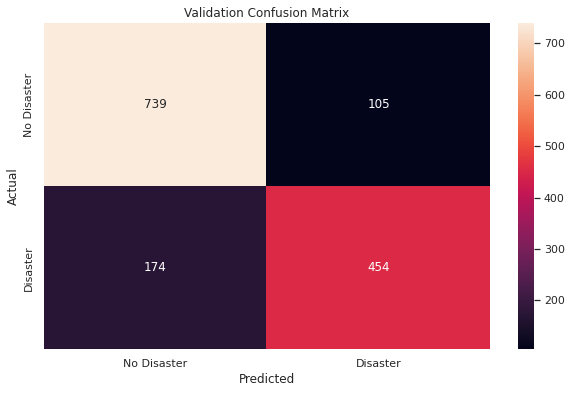

In [ ]:
THRESHOLD = 0.5 # Default value
# Get the true negative, false positive, false negative, and true positive values
tn, fp, fn, tp = confusion_matrix(val_target, val_predict > THRESHOLD).flatten()
# Construct the dataframe
cm = pd.DataFrame(
                    [[tn, fp], [fn, tp]], 
                    index=['No Disaster', 'Disaster'], 
                    columns=['No Disaster', 'Disaster']
)
# Plot the matrix
sns.heatmap(cm, annot=True, fmt='g')    
plt.title('Validation Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()